# Loading in libraries and plotting functions

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import colors
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from IPython.display import display, Markdown
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


def procData(data, title):
    """Process data and provide descriptive statistics
    """
    # Create dataframe
    df = pd.DataFrame({
        "Potatoes": data[:, 0],
        "Nutrients": data[:, 1],
        "Worms": data[:, 2]
    })

    # Get descriptive statistics and drop unneeded info
    dfd = df.describe().drop(["25%", "50%", "75%", "count"])

    # Calculate percentage of missing values
    missings = df.isnull().sum() / 50 * 100

    # Append missing column to dataframe
    dfd = dfd.append(pd.DataFrame({"Missing (%)": missings}).T)

    # Fix labels for pretty printing later on
    dfd["Greenhouse"] = title[-1]
    dfd["Statistics"] = dfd.index
    return dfd


def plotplot(ax, t, title, data, lights, td, mtype, alpha=0.7):
    """Plot the dynamics based on the given type
    """
    # Unpack data
    #     data *= 10
    P, S, W = data[:, 0], data[:, 1], data[:, 2]

    if td:
        if mtype == "d":
            # Plot
            ax.plot(t,
                    P,
                    mtype + 'b',
                    alpha=0.7,
                    markerfacecolor="None",
                    markeredgecolor='b',
                    markersize=10,
                    label='D2-Potatoes')
            ax.plot(t,
                    S,
                    mtype + 'r',
                    alpha=0.7,
                    markerfacecolor="None",
                    markeredgecolor='r',
                    markersize=10,
                    label='D2-Nutrients')
            ax.plot(t,
                    W,
                    mtype + 'g',
                    alpha=0.7,
                    markerfacecolor="None",
                    markeredgecolor='g',
                    markersize=10,
                    label='D2-Worms')
        elif mtype == "-":
            # Plot simulation data
            ax.plot(t,
                    P,
                    'cornflowerblue',
                    alpha=alpha,
                    lw=3,
                    label='S-potatoes')
            ax.plot(t, S, 'lightcoral', alpha=alpha, lw=3, label='S-Nutrients')
            ax.plot(t, W, 'limegreen', alpha=alpha, lw=3, label='S-Worms')
        else:
            ax.plot(t,
                    P,
                    mtype + 'b',
                    alpha=0.7,
                    markersize=8,
                    label='D1-Potatoes')
            ax.plot(t,
                    S,
                    mtype + 'r',
                    alpha=0.7,
                    markersize=8,
                    label='D1-Nutrients')
            ax.plot(t,
                    W,
                    mtype + 'g',
                    alpha=0.7,
                    markersize=8,
                    label='D1-Worms')
    else:
        # Plot simulation data
        plt.plot(t, P, 'cornflowerblue', alpha=alpha, lw=3, label='S-potatoes')
        plt.plot(t, S, 'lightcoral', alpha=alpha, lw=3, label='S-Nutrients')
        plt.plot(t, W, 'limegreen', alpha=alpha, lw=3, label='S-Worms')

    # Prettyfie that graph
    title = title + f" (Light strength={np.mean(lights)})"
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('Count', fontsize=20)
    ax.set_title(title, fontsize=22)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(17)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(17)

    # Set axis ranges; by default this will put major ticks every 25.
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.set_xlim(0, max(t))
    tmp = np.dstack((P, S, W)).flatten()
    ax.set_ylim(0, max(tmp[~np.isnan(tmp)]) * 1.1)

    # Change major ticks to show every 10.
    ax.xaxis.set_major_locator(MultipleLocator(10))

    # Change minor ticks to show every 5. (10/2 = 5)
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

    # Turn grid on for both major and minor ticks and style minor slightly
    # differently.
    ax.grid(which='major', color='#CCCCCC', linestyle='--', lw=2, alpha=0.9)
    ax.grid(which='minor', color='#CCCCCC', linestyle=':', lw=2, alpha=0.7)
    legend = ax.legend(prop={'size': 18})
    legend.get_frame().set_alpha(0.7)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 16})


def interestPlots(interest,
                  dfunc,
                  figsize_x=6,
                  figsize_y=4,
                  n_columns=2,
                  pturb=(False, 1, 0.2, 9. / 10, 10)):
    """Simulation and visualization wrapper to easily try out different sets of parameters
    """
    # Initialize grid plot
    n_figs = len(interest)
    fig, axes = plt.subplots(nrows=int(np.ceil(n_figs / n_columns)),
                             ncols=n_columns,
                             figsize=(figsize_x * n_columns, figsize_y *
                                      int(np.ceil(n_figs / n_columns))),
                             sharey=True,
                             sharex=False)
    descriptives = []
    datas = []
    all_lights = []

    # Iterate through all simulations of interest
    for wI in range(len(interest)):

        # Set up axes for figure
        if n_columns > 1:
            if np.ceil(n_figs / n_columns) < 2: axs = axes[wI % n_columns]
            else: axs = axes[int(np.floor(wI / n_columns)), wI % n_columns]
        else: axs = axes

        # Some mumbo jumbo for the plot titles
        if interest[wI][3] != 99: st = interest[wI][3]
        else: st = 'off/on/off'
        title = f"Greenhouse {wI+1}"

        # Run simulation
        t, lights, data = simulation(interest[wI], pturb, dfunc)

        # Get descriptives
        descriptives.append(procData(data, title))
        datas.append(data)
        all_lights.append(lights)

        # Get a single plot for the grid
        plotplot(axs, t, title, data, lights, True, "o")

    # Save and show grid plot
    plt.tight_layout()
    plt.show()

    return all_lights, descriptives, datas


def makeTable(lights, descriptives):
    """Create pandas table with descriptive statistics
    """
    # Make table
    df = pd.melt(pd.concat(descriptives),
                 id_vars=['Greenhouse', 'Statistics'],
                 value_vars=['Potatoes', 'Nutrients', 'Worms'],
                 value_name='Values')
    lights = pd.DataFrame({
        "Greenhouse":
        np.linspace(1, 4, 4).astype(int).astype(str),
        "Statistics": ["" for _ in descriptives],
        "variable": ["Lights" for _ in descriptives],
        "Values":
        np.linspace(1.25, 2, len(descriptives))
    })
    df = pd.concat([lights, df], ignore_index=True)
    stats = df.set_index(['Greenhouse', 'variable',
                          'Statistics']).unstack('Greenhouse').round(2)
    display(stats)


def plotHisto(data, title, filename):
    """Plot histogram of parameter values found
    """
    # Creating histogram
    fig, axs = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)
    N, bins, patches = axs.hist(data, bins='auto', density=True)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        axs.spines[s].set_visible(False)

    # Remove x, y ticks
    axs.xaxis.set_ticks_position('none')
    axs.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    axs.xaxis.set_tick_params(pad=5)
    axs.yaxis.set_tick_params(pad=10)

    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(17)

    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(17)

    # Add x, y gridlines
    axs.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.6)

    # Setting color
    fracs = ((N**(1 / 5)) / N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    # Adding extra features
    plt.xlabel("Parameter value", fontsize=20)
    plt.ylabel("Probability", fontsize=20)
    axs.yaxis.set_major_formatter(PercentFormatter(decimals=0))
    # legend = ['Distribution $a_1\ &\ a_3$']
    # plt.legend(legend)
    plt.title(title, fontsize=25)
    plt.show()


def plotWithError(all_data, datapoints, test):
    """Create a plot with error bars
    """
    # Extract area
    max0_data = [all_data[:, t][:, 0].max() for t in range(len(all_data[0]))]
    min0_data = [all_data[:, t][:, 0].min() for t in range(len(all_data[0]))]
    max1_data = [all_data[:, t][:, 1].max() for t in range(len(all_data[0]))]
    min1_data = [all_data[:, t][:, 1].min() for t in range(len(all_data[0]))]
    max2_data = [all_data[:, t][:, 2].max() for t in range(len(all_data[0]))]
    min2_data = [all_data[:, t][:, 2].min() for t in range(len(all_data[0]))]

    # Set axes
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))

    # Plot data
    plotplot(axs, t, "tmp", datapoints, lights, True, "o")
    plotplot(axs, t, "tmp", test, lights, True, "d")

    # Get best of the bunch
    best_parameters = np.argmax(scores)

    # Plot best fit
    plotplot(axs, t, "Simulation data and gathered data\n",
             all_data[best_parameters], lights, False, "o")

    # Plot area
    plt.plot(t, max0_data, 'cornflowerblue', alpha=0.3)
    plt.plot(t, min0_data, 'cornflowerblue', alpha=0.3)
    plt.fill_between(t,
                     max0_data,
                     min0_data,
                     color='cornflowerblue',
                     alpha=0.1)
    plt.plot(t, max1_data, 'lightcoral', alpha=0.3)
    plt.plot(t, min1_data, 'lightcoral', alpha=0.3)
    plt.fill_between(t, max1_data, min1_data, color='lightcoral', alpha=0.1)
    plt.plot(t, max2_data, 'limegreen', alpha=0.3)
    plt.plot(t, min2_data, 'limegreen', alpha=0.3)
    plt.fill_between(t, max2_data, min2_data, color='limegreen', alpha=0.1)

    # Some prettyfication
    axs.set_ylim((0, 10))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print score
    display(
        Markdown(
            "#### Calculate the ratio of training set score and test set score to see how compatible they are (extensibility)"
        ))
    print(
        f"Score (MAD) (train - optim): {scoreFunc(datapoints, all_data[best_parameters])}"
    )
    print(
        f"Score (MAD) (test - optim): {scoreFunc(test, all_data[best_parameters])}"
    )
    print(
        f"Score (MAD) (true - optim): {scoreFunc(true_data, all_data[best_parameters])}"
    )
    print(
        f"Train - Test ratio: {(scoreFunc(datapoints, all_data[best_parameters]) / scoreFunc(test, all_data[best_parameters])) * 100}"
    )

# Run different farms
## Initializing functions

In [2]:
def sigmoid(x, height=1, base=0, shift=0.5, slope=10):
    """Sigmoidal function that, using default values is bounded between [0,1] for both axes.
    """
    return base + (height * (1 / (1 + np.exp((-x + shift) * slope))))


def scoreFunc(tdata, data):
    """Scorefunction mean absolute difference
    """
    abs_diff = np.abs(tdata[:, 0] - data[:, 0])
    return abs_diff[~np.isnan(abs_diff)].mean()


# Defining model differential equations
def deriv1(y, t, days, l_on, l_off, steps, a, f, polarity):
    """Set of ODE's first scenario
    """
    p, s, w = y

    light = calcLight(days, l_on, l_off, steps, t)

    dp = sum([
        # Influence of nutrients in the soil on potato growth
        (1. * s**1.5) * (1 * p),
        # Influence of light on potato growth
        +(1.5 * p) * light,
        # Competition with themselves
        -(0.85 * f[0](p)),
        # Potato loss due to worms
        -(2 * w) * (1. * p)
    ])
    ds = sum([
        # Soil nutrient consumption from potatoes
        (-1. * p**1.5) * (1 * s),
        # Worm contribution by feces to soil nutrients
        +(0.3 * w)
    ])
    dw = sum([
        # Toxic effect of too much nutrients on worm population
        (-2 * s) * (1 * w),
        # Migration caused by potatoes
        +(1.2 * p),
        # Worm birth
        +(0.1 * w),
        # Worm death
        -(a[0] * w)
    ])

    return dp, ds, dw


# Defining model differential equations
def deriv2(y, t, days, l_on, l_off, steps, a, f, polarity):
    """Set of ODE's second scenario
    """
    p, s, w = y

    light = calcLight(days, l_on, l_off, steps, t)

    dp = sum([
        # Influence of nutrients in the soil on potato growth
        (1. * s**a[0]) * (1 * p),
        # Influence of light on potato growth
        +(1.5 * p) * light,
        # Competition with themselves
        -(a[1] * f[0](p)),
        # Potato loss due to worms
        -(2 * w) * (1. * p)
    ])
    ds = sum([
        # Soil nutrient consumption from potatoes
        (-1. * p**a[0]) * (1 * s),
        # Worm contribution by feces to soil nutrients
        +(0.3 * w)
    ])
    dw = sum([
        # Toxic effect of too much nutrients on worm population
        (-2 * s) * (1 * w),
        # Migration caused by potatoes
        +(1.2 * p),
        # Worm birth
        +(0.1 * w),
        # Worm death
        -(0.1 * w),
        polarity[0] * (0 * f[1](w) * light)
    ])

    return dp, ds, dw


def calcLight(days, l_on, l_off, steps, t):
    """Calculate strength of light, depending on lightswitch
    """
    # Initialize steps
    l_steps = np.linspace(l_off, l_on, steps)
    t_steps = np.linspace(0, 1, steps + 1)
    light = 0

    # If light is 99 make the light go: off => on => off
    # Distribute light in stepwise fashion otherwise
    if steps != 99:
        for i in range(len(l_steps)):
            if days * t_steps[i] <= t <= days * t_steps[i + 1]:
                light = l_steps[i]
    else:
        if days * 0.25 <= t <= days * 0.75:
            light = l_on
        else:
            light = l_off
    return light


def simulation(simSettings, pturb, dfunc):
    """Simulation itself
    """
    # Unpack settings
    days, l_on, l_off, steps, y0, measurements, simP, simF, simPol = simSettings
    pTrue, pmean, pstd, prem = pturb

    # Set up time and lights
    t = np.linspace(1, days, days * measurements)
    lights = [calcLight(days, l_on, l_off, steps, i) for i in t]

    # Run simulation
    data = odeint(dfunc,
                  y0,
                  t,
                  args=(days, l_on, l_off, steps, simP, simF, simPol))

    # Perturb data to simulate missing values and error
    if pTrue: perturb(pmean, pstd, data, prem)

    return t, lights, data * 10


def perturb(pmean, pstd, data, prem):
    """Perturb the data
    """
    # Get perturbation vector
    perturb = np.random.normal(pmean, pstd, data.shape)

    # Perturb data
    data *= perturb

    # Choose certain ratio of the data by random to illustrate loss of data
    masks = np.random.choice([np.nan, 1],
                             size=(data.shape),
                             p=[prem, 1 - prem])

    # Throw away "lost" data
    data *= masks

    return data

## Calculating farm data
Creating a dataset for 4 farms that differ only in their light strength and the parameter values.

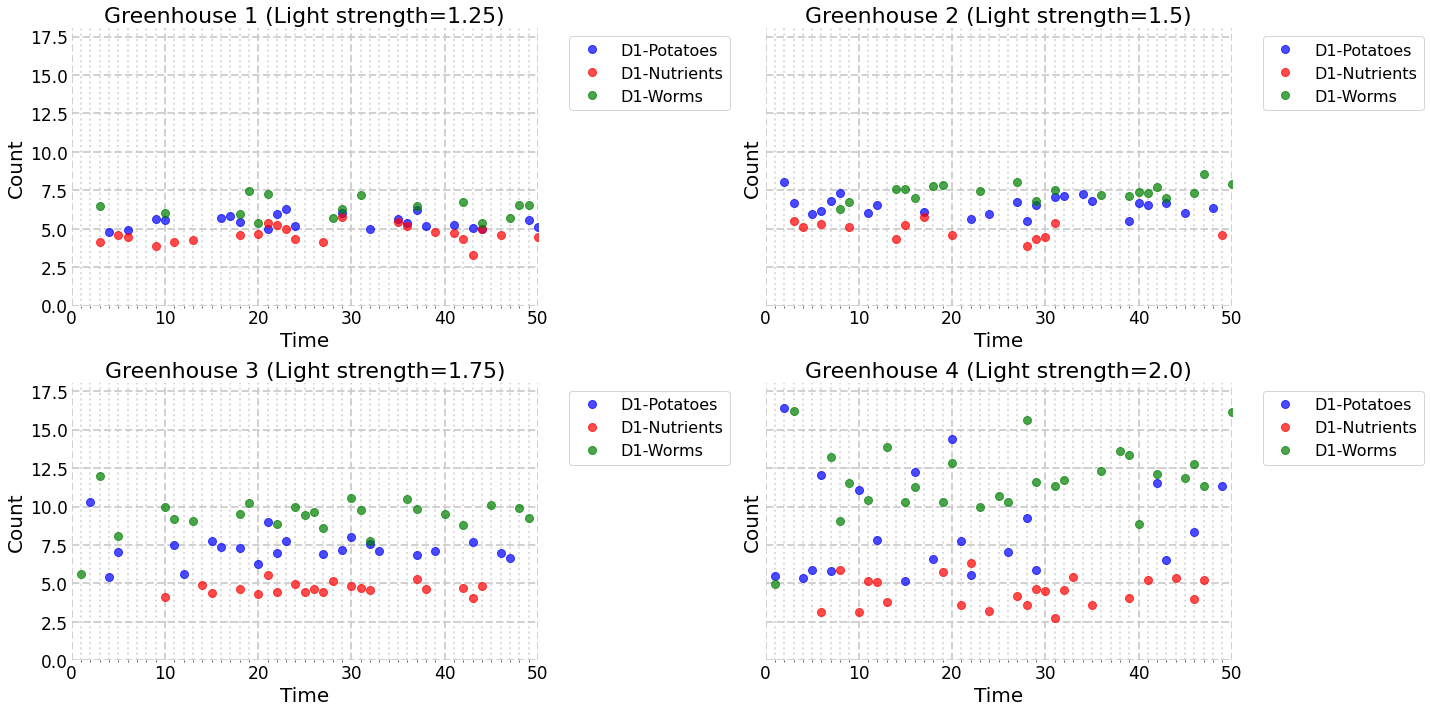

Values                     
Greenhouse                 1      2      3      4
variable  Statistics                             
Lights                  1.25   1.50   1.75   2.00
Nutrients Missing (%)  54.00  74.00  60.00  54.00
          max           5.78   5.77   5.55   6.30
          mean          4.64   4.90   4.67   4.44
          min           3.30   3.90   4.07   2.77
          std           0.56   0.56   0.37   1.00
Potatoes  Missing (%)  56.00  52.00  56.00  58.00
          max           6.27   8.03  10.28  16.39
          mean          5.44   6.50   7.29   8.64
          min           4.76   5.50   5.43   5.14
          std           0.44   0.61   1.01   3.30
Worms     Missing (%)  70.00  60.00  54.00  46.00
          max           7.47   8.55  11.99  16.22
          mean          6.35   7.41   9.40  11.76
          min           5.38   6.29   5.63   4.96
          std           0.65   0.51   1.20   2.36

In [3]:
np.random.seed(89)
interest = [
    # days, lights on, lights off, steps, starting values => (p,s,w)
    # resolution of measurements (x*t), parameters, functions
    [50, 1.25, 1.25, 1, (0.5, 0.5, 0.5), 1, [0.115], [sigmoid], []],
    [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, [0.12], [sigmoid], []],
    [50, 1.75, 1.75, 1, (0.5, 0.5, 0.5), 1, [0.08], [sigmoid], []],
    [50, 2, 2, 1, (0.5, 0.5, 0.5), 1, [0.11], [sigmoid], []],
]

pturb = [True, 1, 0.1, 6. / 10]

lights, descriptives, datas = interestPlots(interest,
              deriv1,
              figsize_x=10,
              figsize_y=5,
              n_columns=2,
              pturb=pturb)

makeTable(lights, descriptives)

## Plot best possible fit

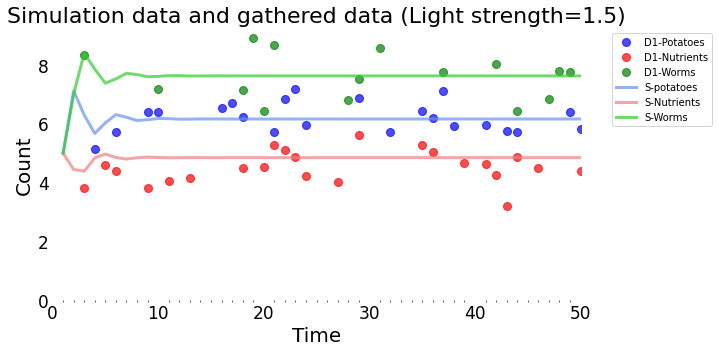

#### Minimum mean absolute difference: 0.4165016665244291

In [4]:
# Set axes
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Set parameters
a = [1.5, 0.85]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]

# Get data
np.random.seed(89)
t, lights, tdata = simulation(simSettings, pturb, deriv2)
plotplot(axs, t, "tmp", tdata, lights, True, "o")

# # start simulation
a = [1.55, 0.85]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [False, 1, 0.1, 6. / 10]

t, lights, data = simulation(simSettings, pturb, deriv2)
plotplot(axs, t, "Simulation data and gathered data", data, lights, False, "o")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

display(Markdown(f"#### Minimum mean absolute difference: {scoreFunc(tdata, data)}"))

# Split data into seen and unseen data

In [5]:
def splitData(true_data, fraction_train):
    """Split data into seen (training set) and unseen (test set) data
    """
    # Get a randomized list of data indices
    nonnans = np.argwhere(~np.isnan(true_data))
    index = np.arange(len(nonnans))
    np.random.shuffle(index)

    # Copy original data structure to not mutate it
    train = true_data.copy()
    test = true_data.copy()
    
    # Make division of data
    div = int(np.floor(len(index) * fraction_train))
    test_nan = index[:div]
    train_nan = index[div:]

    # Rebuild data into the two sets
    for i in train_nan:
        ti = nonnans[i]
        train[ti[0]][ti[1]] = np.nan
    for i in test_nan:
        ti = nonnans[i]
        test[ti[0]][ti[1]] = np.nan

    return train, test

In [6]:
# Set parameter values
a = [1.5, 0.85]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]
dump_ratio = 3 / 9

# Get data
np.random.seed(89)
t, lights, true_data = simulation(simSettings, pturb, deriv2)

# Split data
train, test = splitData(true_data, 2 / 3)

# Parameter calibration (metropolis hastings)
## Initialize function

In [7]:
def metro_hast(tdata, simSettings, bestp, fs, polarity, pturb, N):
    """Metropolis hastings algorithm that samples parameter space
    """
    # start simulation
    t, lights, data = simulation(simSettings, pturb, deriv2)
    scores = [scoreFunc(tdata, data)]
    all_data = [data]

    for i in tqdm(range(N)):
        # Perturb parameters slightly
        newp = np.random.normal(bestp[-1], 0.005, 2)
        # Set new settings
        simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, newp, fs, polarity]
        # Run simulation
        t, lights, data = simulation(simSettings, pturb, deriv2)
        # Calculate score
        news = scoreFunc(tdata, data)
        # See if score is better than the last iteration and keep if it is
        if news <= scores[-1]:
            scores.append(news)
            bestp.append(newp)
            all_data.append(data)
        # Or else give a random chance to still be accepted
        else:
            random = np.random.rand()
            if random < scores[-1] / news:
                scores.append(news)
                bestp.append(newp)
                all_data.append(data)
    return scores, np.array(bestp), np.array(all_data)


## Calibrate parameter values

In [ ]:
# Set parameters
bestp = [np.array([1.5, 0.85])]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, bestp[-1], fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]

# Get data
np.random.seed(89)
t, lights, tdata = simulation(simSettings, pturb, deriv2)

# Run metropolis-hastings
pturb = [False, 1, 0.1, 6. / 10]

# Run metrop
scores, bestp, all_data = metro_hast(train, simSettings, bestp, fs, polarity,
                                     pturb, 1000)

 63%|██████▎   | 626/1000 [00:33<00:19, 19.25it/s]

## Make barchart of parameter calibration

In [ ]:
title = r'Parameter distribution parameter $a_1$ and $a_3$'
# print(f"Variance: {np.var(bestp[:,0])}")
plotHisto(bestp[:, 0], title, "a1_3.png")
title = r'Parameter distribution parameter $a_2$'
# print(f"Variance: {np.var(bestp[:,1])}")
plotHisto(bestp[:, 1], title, "a2.png")

## Plot with error area and print cost function on best parameters

In [ ]:
# Run simulation
plotWithError(all_data, train, test)

# Pick MAP and compare seen vs unseen dataset

In [ ]:
# Set parameters
bestp = [np.array([1.5, 0.85])]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, bestp[-1], fs, polarity]
pturb = [False, 1, 0.1, 6. / 10]

# Get data
np.random.seed(89)
t, lights, MLEdata = simulation(simSettings, pturb, deriv2)

# Set plot parameters
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plotplot(axs, t, "tmp", train, lights, True, "o")
plotplot(axs, t, "tmp", test, lights, True, "d")
plotplot(axs, t, "MAP on dataset 1 and 2", MLEdata, lights, False, "")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate both score functions
trainScore = scoreFunc(train, MLEdata)
testScore = scoreFunc(test, MLEdata)

display(Markdown(
    f"#### Train: {trainScore}\n#### Test: {testScore}\n#### Diff percentage: {trainScore/testScore}"
))

# Fit on lights
## Getting the noisy data

In [ ]:
np.random.seed(89)
# Run 
interest = [
    # days, lights on, lights off, steps, starting values => (p,s,w)
    # resolution of measurements (x*t), parameters, functions
    [50, 1.25, 1.25, 1, (0.5, 0.5, 0.5), 1, [0.115], [sigmoid], []],
    [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, [0.12], [sigmoid], []],
    [50, 1.75, 1.75, 1, (0.5, 0.5, 0.5), 1, [0.08], [sigmoid], []],
    [50, 2, 2, 1, (0.5, 0.5, 0.5), 1, [0.11], [sigmoid], []],
]

pturb = [True, 1, 0.1, 6. / 10]

lights, descriptives, datas_true = interestPlots(interest,
              deriv1,
              figsize_x=10,
              figsize_y=5,
              n_columns=2,
              pturb=pturb)

## Getting unperturbed data

In [ ]:
np.random.seed(89)
interest = [
    # days, lights on, lights off, steps, starting values => (p,s,w)
    # resolution of measurements (x*t), parameters, functions
    [50, 1.25, 1.25, 1, (0.5, 0.5, 0.5), 1, [1.5, 0.85], [sigmoid, sigmoid], [0]],
    [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, [1.5, 0.85], [sigmoid, sigmoid], [0]],
    [50, 1.75, 1.75, 1, (0.5, 0.5, 0.5), 1, [1.5, 0.85], [sigmoid, sigmoid], [0]],
    [50, 2, 2, 1, (0.5, 0.5, 0.5), 1, [1.5, 0.85], [sigmoid, sigmoid], [0]],
]

pturb = [False, 1, 0.1, 6. / 10]

lights, descriptives, datas_sim = interestPlots(interest,
              deriv2,
              figsize_x=10,
              figsize_y=5,
              n_columns=2,
              pturb=pturb)

## Plotting best fit

In [ ]:
scores_lights = [str(round(scoreFunc(datas_true[i], datas_sim[i]),3)) for i in range(len(datas_sim))]

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
y = [0,1,0,1]
x = [0,0,1,1]
for i in range(len(datas_sim)):
    plotplot(axs[x[i]][y[i]], t, "MAP: " + scores_lights[i], datas_true[i], lights[i], True, "o")
    plotplot(axs[x[i]][y[i]], t, "MAP: " + scores_lights[i], datas_sim[i], lights[i], True, "-")
plt.tight_layout()
plt.show()